In [ ]:
# PART 5 IMPROVED CNN USING PYTROCH : ADDED DROPOUT AND TRANSFORMS. 

In [1]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision
import torch.optim as optim

In [2]:
class A4Net(nn.Module):
    
    def __init__(self):
        super(A4Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3) # kernel size can be an int (for sqaure kernels) or tuple (generic)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.drop1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.drop2 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.relu3 = nn.ReLU()
        # is reshape layer explicitly needed ??? 
        self.fc1 = nn.Linear(576, 64) 
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
        self.softmax= nn.Softmax()

        ## softmax activation after fc2 for faster convergence
    
    def forward(self, x):
      
         y = self.conv1(x)
         y = self.relu1(y)
         y = self.pool1(y)
         y = self.conv2(y)
         y = self.relu2(y)
         y = self.pool2(y)
         y = self.conv3(y)        
         y = self.relu3(y)
         y=  torch.reshape(y,(-1,576))                     
         y = self.fc1(y)
         y = self.relu4(y)
         y = self.fc2(y)    
        #  y = self.softmax(y)
        
         return y
      
    

In [9]:
# For cifar-10 you get pre-built loaders

transform_train = T.Compose([T.RandomHorizontalFlip(),T.RandomCrop(32, padding=4),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transforms = T.Compose([T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

traindata = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train,download=True)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True, num_workers=4)
trainloader2 = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True, num_workers=4)

valdata = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms)
valloader = torch.utils.data.DataLoader(valdata, batch_size=32, shuffle=False, num_workers=4)

Files already downloaded and verified


In [10]:
global_plot_num=10

In [11]:
lrArray=[0.001,0.01,0.0003,0.0001]
batchArray=[4,8,16,32]

Epoch Level Loss is  2.235231500593272
Epoch Level Loss is  1.9537816979682225
Epoch Level Loss is  1.8044023720484397
Epoch Level Loss is  1.7315512821602654
Epoch Level Loss is  1.6586181097738422
Epoch Level Loss is  1.5888140679778613
Epoch Level Loss is  1.5292990321313733
Epoch Level Loss is  1.4836537651503154
Epoch Level Loss is  1.4368781776513644
Epoch Level Loss is  1.3973778895056561
Epoch Level Loss is  1.3545893039828452
Epoch Level Loss is  1.3101865559987966
Epoch Level Loss is  1.2804543425162787


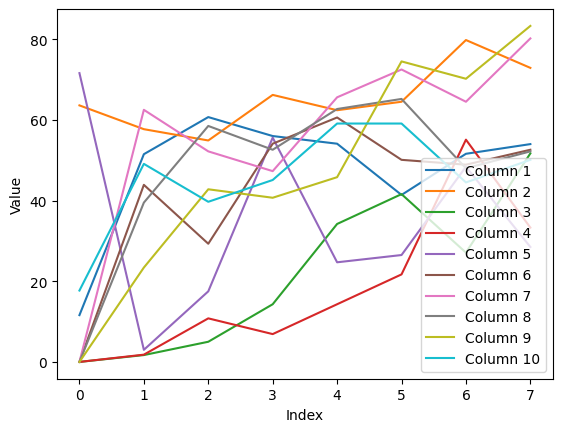

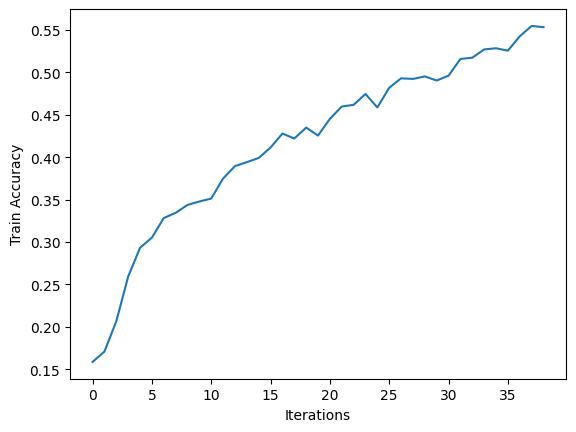

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

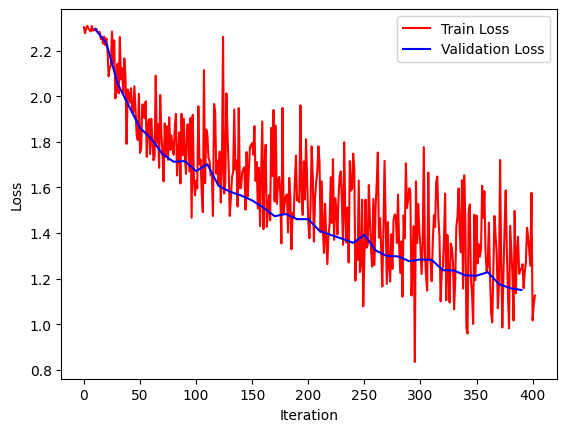

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1920x1440 with 0 Axes>

In [12]:
# Components: model, loss, optimizer, data loader
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
# Components: model, loss, optimizer, data loader

## Data loader is a generator --> (X, y) pairs for your dataset --> batch size x (image tensor, label tensor)
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
from torch.optim.lr_scheduler import * # Import your choice of scheduler here
epArray=[25]
for epoch_num in epArray:        
    class_accuracies=[]
    model = A4Net()
    ## Signature might not be accurate 
    ## selectively train different layers, and freeze others
    #for param in model.parameters:
    #    param.requires_grad = False
    #model.fc1.requires_grad = True
    LEARNING_RATE=0.001

    loss_fn = nn.CrossEntropyLoss() # change this for other losses
    optimizer = optim.Adam(model.parameters(),lr= LEARNING_RATE)
    # optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE , momentum=0.9)
    scheduler = CosineAnnealingLR(optimizer,T_max = 32, eta_min = 1e-6) # Multiplicative factor of learning rate decay


    # scheduler = ExponentialLR(optimizer,gamma=0.95) # Multiplicative factor of learning rate decay
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = epoch_num
    model.to(device)
    trainlosses=[]
    vallosses=[]
    train_accuracies=[]
    epoch_loss_array=[]
    for epoch in range(epochs):
        epoch_loss = 0.0
        iter=0
        for images, labels in trainloader:
            iter+=1
            # print(images.shape)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if((iter%500)==0):
                total_correct=0
                total_samples=0
                for ims, lbs in trainloader2:
                  ims = ims.to(device)
                  lbs = lbs.to(device)

                  outputs_train = model(ims)
                  _, predicted_train = torch.max(outputs_train, dim=1)

                  total_correct += torch.sum(predicted_train == lbs).item()
                  total_samples += lbs.size(0)
                train_accuracies.append(total_correct / total_samples)
                class_correct = {i: 0 for i in range(10)}
                class_total = {i: 0 for i in range(10)}
                loss_val=0
                val_iter=0
                for val_images,val_labels in valloader:
                  val_iter+=1
                  val_images, val_labels = val_images.to(device), val_labels.to(device)
                  model_output= model(val_images)
                  loss_val += loss_fn(model_output,val_labels).item()
                  _, predicted = torch.max(model_output, 1)
                  for i in range(val_labels.size(0)):
                    label = val_labels[i].item()
                    class_correct[label] += (predicted[i] == label).item()
                    class_total[label] += 1
                # print("v ",loss_val/val_iter)
                for i in range(10):
                  acc = 100.0 * class_correct[i] / class_total[i]
                  # print('Accuracy of %5s : %2d %%' % (i, acc))
                  class_accuracies.append(acc)
                vallosses.append(loss_val/val_iter)
                # print("val loss is ", loss_val)
            
            # print(labels.shape,outputs.shape)
            
            loss = loss_fn( outputs,labels)
            if((iter%50)==0):
              trainlosses.append(loss.item())
              # print(loss.item())
            loss.backward()
            # print(optimizer.param_groups[0]["lr"],loss.item())
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()
        print("Epoch Level Loss is ",  epoch_loss/iter)  
        epoch_loss_array.append(epoch_loss/iter)
        # saving the model weights for all epochs
        # save_path = "./toy_model_%s.pth"%epoch
    
        # torch.save(model.state_dict(), save_path)
    
    class_perf=np.array(class_accuracies)
    class_perf=class_perf.reshape((-1,10))
    class_perf = class_perf[::5]

# Plot all the columns in a single graph
    for i in range(class_perf.shape[1]):
        plt.plot(class_perf[:, i], label=f"Column {i+1}")

    # Add a legend and axis labels
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Value")

    # Display the plot
    plt.show()
    plt.clf()

    plt.plot(train_accuracies)
    plt.xlabel("Iterations")
    plt.ylabel("Train Accuracy")
    plt.show()
    plt.clf()

    np.savetxt('my_array.txt'+str(global_plot_num), epoch_loss_array)
    files.download('my_array.txt'+str(global_plot_num))

    # Create some example data
    # train_losses = [0.5, 0.4, 0.3, 0.2, 0.1] * 10 # Replace with your train losses
    # val_losses = [0.4, 0.3, 0.2, 0.1,0.6] # Replace with your validation losses

    marker_size = 2
    dpi = 300


    # Plot the train losses
    plt.plot(range(len(trainlosses)), trainlosses, 'r-', label='Train Loss')

    # Plot the validation losses
    x_vals = [(i*10+10) for i in range(len(vallosses))] # Scale the x-axis to match the train losses
    plt.plot(x_vals, vallosses, 'b-', label='Validation Loss')

    # Add a legend and axis labels
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.rcParams['figure.dpi'] = dpi
    # Display the plot
    # plt.show()
    filename = 'loss_plot'+str(global_plot_num)+'.png'
    global_plot_num+=1
    plt.show()
    plt.savefig(filename)
    files.download(filename)
    plt.clf()

In [13]:
# cmodel = A4Net()
# model.load_state_dict(torch.load(save_path)) # pass the model weight path

# for images, labels in valloader:
#     outputs = model(images)
#     # logits/ probabilities (if you use softmax) batch_size x 10 [p1, p2, ... p10]
#     _, preds = torch.max(outputs, 1)
#     print("GT: %s, Pred: %s"%(labels.tolist(), preds.tolist()))
#     # ToDo: for accuracy calculation, track the GT and Predictions


In [14]:
# import matplotlib.pyplot as plt

# # Create some example data
# train_losses = [0.5, 0.4, 0.3, 0.2, 0.1] * 10 # Replace with your train losses
# val_losses = [0.4, 0.3, 0.2, 0.1,0.6] # Replace with your validation losses

# marker_size = 2
# dpi = 300


# # Plot the train losses
# plt.plot(range(len(train_losses)), train_losses, 'r-', label='Train Loss')

# # Plot the validation losses
# x_vals = [(i*10+10) for i in range(len(val_losses))] # Scale the x-axis to match the train losses
# plt.plot(x_vals, val_losses, 'b-', label='Validation Loss')

# # Add a legend and axis labels
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.rcParams['figure.dpi'] = dpi
# # Display the plot
# plt.show()
# num=2
# filename = 'loss_plot'+str(num)+'.png'
# plt.savefig(filename)
# files.download(filename)